##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Guided Evolutionary Strategies Demo (using TensorFlow 2)

Date: 06/08/2020

This is a self-contained notebook that reproduces the toy example in Fig. 1 of the [Guided ES](https://arxiv.org/abs/1806.10230) paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

TensorFlow version: 2.2.0
TensorFlow Probability version: 0.10.0


### Problem setup

We test the algorithms on a toy problem where we explicitly add bias and variance to the gradient.

In [3]:
# Generate problem data.
rs = np.random.RandomState(seed=0)
m = 2000  # Number of data points.
n = 1000  # Number of variables.

A = rs.randn(m, n)
b = rs.randn(m, 1)

xstar = np.linalg.lstsq(A, b, rcond=None)[0]
f_star = (0.5/float(m)) * np.linalg.norm(np.dot(A, xstar) - b) ** 2

A = tf.convert_to_tensor(A, dtype=tf.float32)
b = tf.convert_to_tensor(b, dtype=tf.float32)

# This is a bias vector that will be added to the gradient
grad_bias = 1.0 * tf.nn.l2_normalize(tf.convert_to_tensor(rs.randn(n, 1), dtype=tf.float32))

@tf.function
def loss_and_grad_fun(x):
    residual = tf.matmul(A, x) - b
    loss = 0.5 * tf.norm(residual) ** 2 / float(m)
    
    # The 'gradient' that we observe is a noisy, biased version of the true gradient.
    # This is meant to mimic scenarios where we only have access to biased gradients.
    err = tf.matmul(tf.transpose(A), residual) / float(m)
    grad_noise = 1.5 * tf.nn.l2_normalize(tf.random.normal(shape=(n, 1)))
    gradient = err + (grad_bias + grad_noise) * tf.norm(err)
    
    return loss, gradient

### Algorithm 1: Gradient Descent

Our first algorithm is gradient descent, applied directly to the biased gradients.

In [4]:
opt = tf.keras.optimizers.SGD(5e-3)

@tf.function
def step_fun(x):
    loss, gradient = loss_and_grad_fun(x)
    opt.apply_gradients([(gradient, x)])
    return loss

In [5]:
%%time

x = tf.Variable(tf.zeros((n, 1)), dtype=tf.float32)

fobj = []
for k in range(10000):
    fobj.append(step_fun(x))
    
# Store training curve for plotting later.
f_gd = tf.stack(fobj).numpy().copy()

CPU times: user 11.6 s, sys: 746 ms, total: 12.3 s
Wall time: 10.4 s


### Algorithm 2: Vanilla Evolutionary Strategies (Vanilla ES)

Our next algorithm is vanilla (standard) evolutionary strategies. This is a zeroth-order optimization algorithm, which means that it only uses the function evaluation (and ignores the biased gradients).

In [6]:
# Hyperparameters for Vanilla ES
sigma = 0.1
beta = 1.0
learning_rate = 0.2

# Defines the distribution for sampling parameter perturbations.
scale_diag = (sigma / np.sqrt(n)) * tf.ones((n, 1))
dist = tfp.distributions.MultivariateNormalDiag(scale_diag=scale_diag)

opt = tf.keras.optimizers.SGD(learning_rate)

@tf.function
def step_fun(x):
    epsilon = dist.sample()
    
    # We utilize antithetic (positive and negative) samples.
    f_pos, _ = loss_and_grad_fun(x + epsilon)
    f_neg, _ = loss_and_grad_fun(x - epsilon)
    
    # This update is a stochastic finite difference estimate of the true gradient.
    update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
    opt.apply_gradients([(update, x)])
    
    return loss_and_grad_fun(x)[0]

In [7]:
%%time

x = tf.Variable(tf.zeros((n, 1)), dtype=tf.float32)

# Run the optmizer.
fobj = []
for k in range(10000):
    fobj.append(step_fun(x))

# Store training curve for plotting later.
f_ves = tf.stack(fobj).numpy().copy()

CPU times: user 15.2 s, sys: 842 ms, total: 16.1 s
Wall time: 11.3 s


### Algorithm 3: Guided Evolutionary Strategies (Guided ES)

Guided ES is our proposed method. It uses a diagonal plus low-rank covariance matrix for drawing perturbations, where the low-rank subspace is spanned by the available gradient information.

This allows it to incorporate the biased gradient information, while still minimizing the true loss function.

In [8]:
# Hyperparameters for Guided ES
sigma = 0.1
alpha = 0.5
beta = 1.0
k = 1        # Defines the dimensionality of the low-rank subspace.

# Defines parameters of the distribution for sampling perturbations.
a = sigma * np.sqrt(alpha / float(n))
c = sigma * np.sqrt((1. - alpha) / float(k))
b = np.sqrt(a ** 2 + c ** 2) - a

scale_diag = a * tf.ones(n)
perturb_diag = b * tf.ones(1)


opt = tf.keras.optimizers.SGD(0.2)

@tf.function
def step_fun(x):
    
    # We utilize the gradient to generate our sampling distribution.
    loss, gradient = loss_and_grad_fun(x)
    
    # Define the sampling distribution.
    perturb_factor, _ = tf.linalg.qr(gradient)
    dist = tfp.distributions.MultivariateNormalDiagPlusLowRank(scale_diag=scale_diag,
                                                               scale_perturb_factor=perturb_factor,
                                                               scale_perturb_diag=perturb_diag)
    epsilon = tf.reshape(dist.sample(), (-1, 1))
    
    # We utilize antithetic (positive and negative) samples.
    f_pos, _ = loss_and_grad_fun(x + epsilon)
    f_neg, _ = loss_and_grad_fun(x - epsilon)
    
    # This update is a stochastic finite difference estimate of the true gradient.
    update = (beta / (2 * sigma ** 2)) * (f_pos - f_neg) * epsilon
    opt.apply_gradients([(update, x)])

    return loss_and_grad_fun(x)[0]

In [9]:
%%time

x = tf.Variable(tf.zeros((n, 1)), dtype=tf.float32)

# Run the optmizer.
fobj = []
for k in range(10000):
    fobj.append(step_fun(x))

# Store training curve for plotting later.
f_ges = tf.stack(fobj).numpy().copy()

W0608 17:53:00.466533 4451732928 deprecation.py:323] From /Users/nirum/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py:332: MultivariateNormalDiagPlusLowRank.__init__ (from tensorflow_probability.python.distributions.mvn_diag_plus_low_rank) is deprecated and will be removed after 2020-01-01.
Instructions for updating:
MultivariateNormalDiagPlusLowRank is deprecated without a planned replacement. If you want equivalent behavior, you can create a MultivariateNormalLinearOperator instance with a LinearOperatorLowRankUpdate scale.
W0608 17:53:00.468010 4451732928 deprecation.py:506] From /Users/nirum/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/linalg/linear_operator_diag.py:166: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
W0608

CPU times: user 22.8 s, sys: 1.02 s, total: 23.8 s
Wall time: 18.2 s


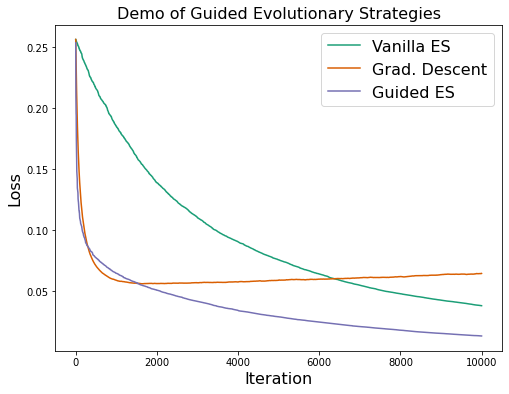

In [11]:
COLORS = {'ges': '#7570b3', 'ves': '#1b9e77', 'sgdm': '#d95f02'}
plt.figure(figsize=(8, 6))
plt.plot(f_ves - f_star, color=COLORS['ves'], label='Vanilla ES')
plt.plot(f_gd - f_star, color=COLORS['sgdm'], label='Grad. Descent')
plt.plot(f_ges - f_star, color=COLORS['ges'], label='Guided ES')
plt.legend(fontsize=16, loc=0)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Demo of Guided Evolutionary Strategies', fontsize=16);